In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import tensorflow as tf


/Users/stev2000/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [88]:
#load one year dataset
df = pd.read_csv('dataset_10_28_18-10_28_19.csv')

In [89]:
df.head()

,Unnamed: 0,time,rps,date,conn_open,bytes_in,bytes_out,kbytes_in,kbytes_out
0,0,1540769776000,7.1000,2018-10-28 23:36:16,1.4000,11860.4000,54388.4667,11.8604,54.3885
1,1,1540769836000,7.5833,2018-10-28 23:37:16,1.2167,12189.1333,60224.0167,12.1891,60.2240
2,2,1540769896000,7.3000,2018-10-28 23:38:16,1.1833,11522.3333,57729.8667,11.5223,57.7299
3,3,1540769957000,8.3667,2018-10-28 23:39:17,1.3500,13384.4667,67755.5167,13.3845,67.7555
4,4,1540770017000,8.3833,2018-10-28 23:40:17,1.3667,13263.7000,67699.9667,13.2637,67.7000


In [74]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [90]:
uni_data = df['rps']
uni_data.index = df['date']
uni_data.head()

date
2018-10-28 23:36:16   7.1000
2018-10-28 23:37:16   7.5833
2018-10-28 23:38:16   7.3000
2018-10-28 23:39:17   8.3667
2018-10-28 23:40:17   8.3833
Name: rps, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1068a3dd0>],
      dtype=object)

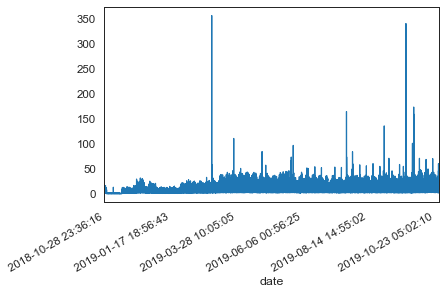

In [6]:
uni_data.plot(subplots=True)

In [91]:
uni_data = uni_data.values

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508220 entries, 0 to 508219
Data columns (total 9 columns):
Unnamed: 0    508220 non-null int64
time          508220 non-null int64
rps           508220 non-null float64
date          508220 non-null object
conn_open     508220 non-null float64
bytes_in      508220 non-null float64
bytes_out     508220 non-null float64
kbytes_in     508220 non-null float64
kbytes_out    508220 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 34.9+ MB


In [92]:
(508220 * 20) / 100

101644.0

In [93]:
TRAIN_SPLIT = 508220 - 101644

In [94]:
uni_data

array([ 7.1       ,  7.58333333,  7.3       , ..., 20.18333333,
       19.06666667, 19.9       ])

In [95]:
'''
It is important to normalize features before training a neural network. 
A common way to do so is by subtracting the mean and 
dividing by the standard deviation of each feature.
'''

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [96]:
#Let's normalize the data.
uni_data = (uni_data-uni_train_mean)/uni_train_std


In [97]:
uni_data

array([-0.52167937, -0.45983791, -0.4960898 , ...,  1.15230478,
        1.0094297 ,  1.11605289])

In [105]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [16]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target rps to predict')
print (y_train_uni[0])

Single window of past history
[[-0.52167937]
 [-0.45983791]
 [-0.4960898 ]
 [-0.35961211]
 [-0.35747965]
 [-0.30203559]
 [-0.32336023]
 [-0.31696283]
 [-0.58352082]
 [-0.36174458]
 [-0.40226139]
 [-0.51314951]
 [-0.31056544]
 [-0.32762515]
 [-0.20394225]
 [-0.38520168]
 [-0.32975762]
 [-0.22313442]
 [-0.31483037]
 [-0.22953182]
 [-0.23592921]
 [-0.35108226]
 [-0.33828747]
 [-0.27857848]
 [-0.2956382 ]
 [-0.12290862]
 [-0.12930601]
 [-0.00562311]
 [-0.23806167]
 [-0.03761007]]

 Target rps to predict
-0.06959702473220106


In [106]:
x_train_uni.shape

(406546, 30, 1)

In [17]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [18]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/Users/stev2000/.pyenv/versions/3.7.4/lib/python3.7/site-packages/matplotlib/pyplot.py'>

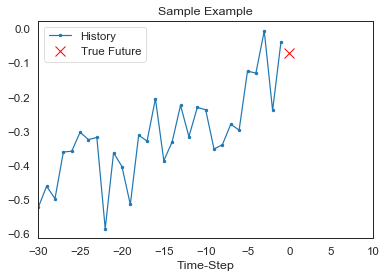

In [19]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [20]:
'''
Baseline
Before proceeding to train a model, let's first set a simple baseline. 
Given an input point, the baseline method looks at all the history and predicts 
the next point to be the average of the last 30 observations.
'''

"\nBaseline\nBefore proceeding to train a model, let's first set a simple baseline. \nGiven an input point, the baseline method looks at all the history and predicts \nthe next point to be the average of the last 30 observations.\n"

In [21]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/stev2000/.pyenv/versions/3.7.4/lib/python3.7/site-packages/matplotlib/pyplot.py'>

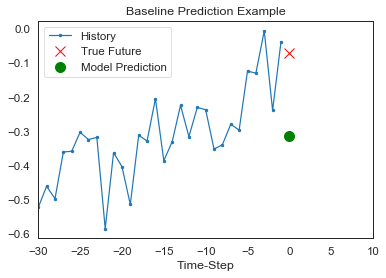

In [22]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,'Baseline Prediction Example')

# LSTM Model Building

In [32]:
model = Sequential()
model.add(LSTM(30, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#TRY MAE later

history = model.fit(x_train_uni, y_train_uni, epochs=20, batch_size=256, validation_data=(x_val_uni, y_val_uni), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 406546 samples, validate on 101614 samples
Epoch 1/20
406546/406546 [==============================] - 61s 150us/step - loss: 0.0567 - val_loss: 0.0848
Epoch 2/20
406546/406546 [==============================] - 64s 158us/step - loss: 0.0428 - val_loss: 0.0799
Epoch 3/20
406546/406546 [==============================] - 64s 158us/step - loss: 0.0417 - val_loss: 0.0782
Epoch 4/20
406546/406546 [==============================] - 68s 167us/step - loss: 0.0411 - val_loss: 0.0775
Epoch 5/20
406546/406546 [==============================] - 64s 157us/step - loss: 0.0408 - val_loss: 0.0765
Epoch 6/20
406546/406546 [==============================] - 58s 142us/step - loss: 0.0406 - val_loss: 0.0765
Epoch 7/20
406546/406546 [==============================] - 58s 144us/step - loss: 0.0408 - val_loss: 0.0756
Epoch 8/20
406546/4065

In [33]:
# make predictions with normalization
test_predict = model.predict(x_val_uni)

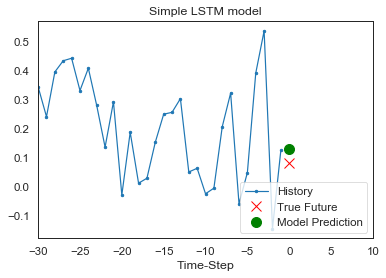

In [36]:

plot = show_plot([x_val_uni[0], y_val_uni[0],test_predict[0]], 0, 'Simple LSTM model')
plot.show()

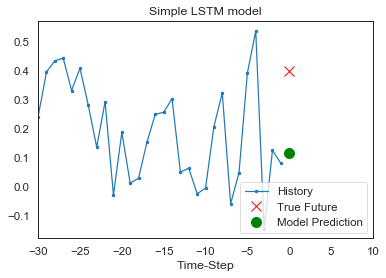

In [37]:
plot = show_plot([x_val_uni[1], y_val_uni[1],test_predict[1]], 0, 'Simple LSTM model')
plot.show()

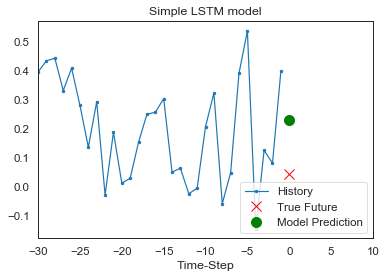

In [38]:
plot = show_plot([x_val_uni[2], y_val_uni[2],test_predict[2]], 0, 'Simple LSTM model')
plot.show()

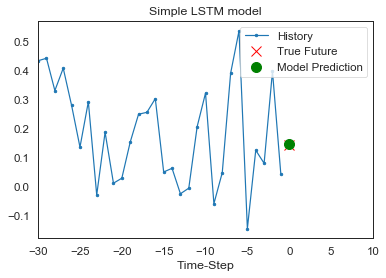

In [39]:
plot = show_plot([x_val_uni[3], y_val_uni[3],test_predict[3]], 0, 'Simple LSTM model')
plot.show()

In [41]:
#Use more historical input
univariate_past_history = 60
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [42]:
model = Sequential()
model.add(LSTM(60, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#TRY MAE later

history = model.fit(x_train_uni, y_train_uni, epochs=20, batch_size=256, validation_data=(x_val_uni, y_val_uni), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 406516 samples, validate on 101584 samples
Epoch 1/20
406516/406516 [==============================] - 213s 525us/step - loss: 0.0459 - val_loss: 0.0803
Epoch 2/20
406516/406516 [==============================] - 213s 524us/step - loss: 0.0379 - val_loss: 0.0776
Epoch 3/20
406516/406516 [==============================] - 7385s 18ms/step - loss: 0.0373 - val_loss: 0.0764
Epoch 4/20
406516/406516 [==============================] - 50563s 124ms/step - loss: 0.0371 - val_loss: 0.0759
Epoch 5/20
406516/406516 [==============================] - 235s 577us/step - loss: 0.0364 - val_loss: 0.0753
Epoch 6/20
406516/406516 [==============================] - 224s 551us/step - loss: 0.0360 - val_loss: 0.0754
Epoch 7/20
406516/406516 [==============================] - 222s 545us/step - loss: 0.0358 - val_loss: 0.0751
Epoch 8/20
406516/406516 [==============================] - 277s 681us/step - loss: 0.0357 - val_loss: 0.0746
Epoch 9/20
406516/406516 [==============================] - 303s 7

In [43]:
# make predictions with normalization
test_predict = model.predict(x_val_uni)

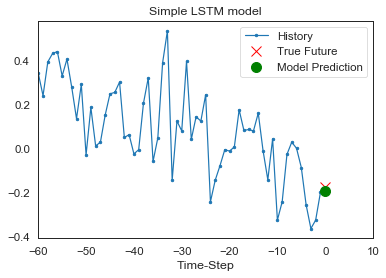

In [44]:
plot = show_plot([x_val_uni[0], y_val_uni[0],test_predict[0]], 0, 'Simple LSTM model')
plot.show()

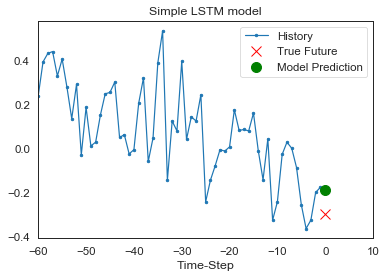

In [45]:
plot = show_plot([x_val_uni[1], y_val_uni[1],test_predict[1]], 0, 'Simple LSTM model')
plot.show()

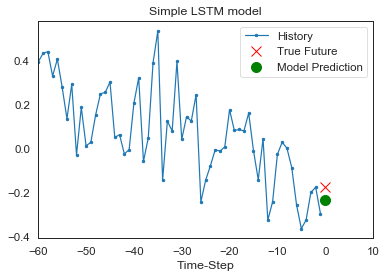

In [46]:
plot = show_plot([x_val_uni[2], y_val_uni[2],test_predict[2]], 0, 'Simple LSTM model')
plot.show()

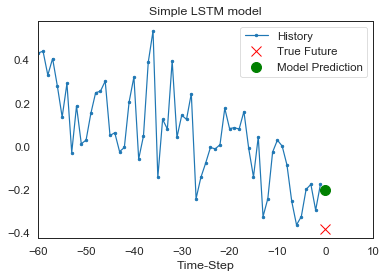

In [57]:
plot = show_plot([x_val_uni[3], y_val_uni[3],test_predict[3]], 0, 'Simple LSTM model')
plot.show()

# Multivariate Time Series

In [49]:
df.head()

,Unnamed: 0,time,rps,date,conn_open,bytes_in,bytes_out,kbytes_in,kbytes_out
0,0,1540769776000,7.1000,2018-10-28 23:36:16,1.4000,11860.4000,54388.4667,11.8604,54.3885
1,1,1540769836000,7.5833,2018-10-28 23:37:16,1.2167,12189.1333,60224.0167,12.1891,60.2240
2,2,1540769896000,7.3000,2018-10-28 23:38:16,1.1833,11522.3333,57729.8667,11.5223,57.7299
3,3,1540769957000,8.3667,2018-10-28 23:39:17,1.3500,13384.4667,67755.5167,13.3845,67.7555
4,4,1540770017000,8.3833,2018-10-28 23:40:17,1.3667,13263.7000,67699.9667,13.2637,67.7000


In [50]:
features_considered = ['rps', 'conn_open', 'kbytes_in', 'kbytes_out']

In [51]:
features = df[features_considered]
features.index = df['date']
features.head()

,rps,conn_open,kbytes_in,kbytes_out
date,,,,
2018-10-28 23:36:16,7.1000,1.4000,11.8604,54.3885
2018-10-28 23:37:16,7.5833,1.2167,12.1891,60.2240
2018-10-28 23:38:16,7.3000,1.1833,11.5223,57.7299
2018-10-28 23:39:17,8.3667,1.3500,13.3845,67.7555
2018-10-28 23:40:17,8.3833,1.3667,13.2637,67.7000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12e12df90>,
      dtype=object)

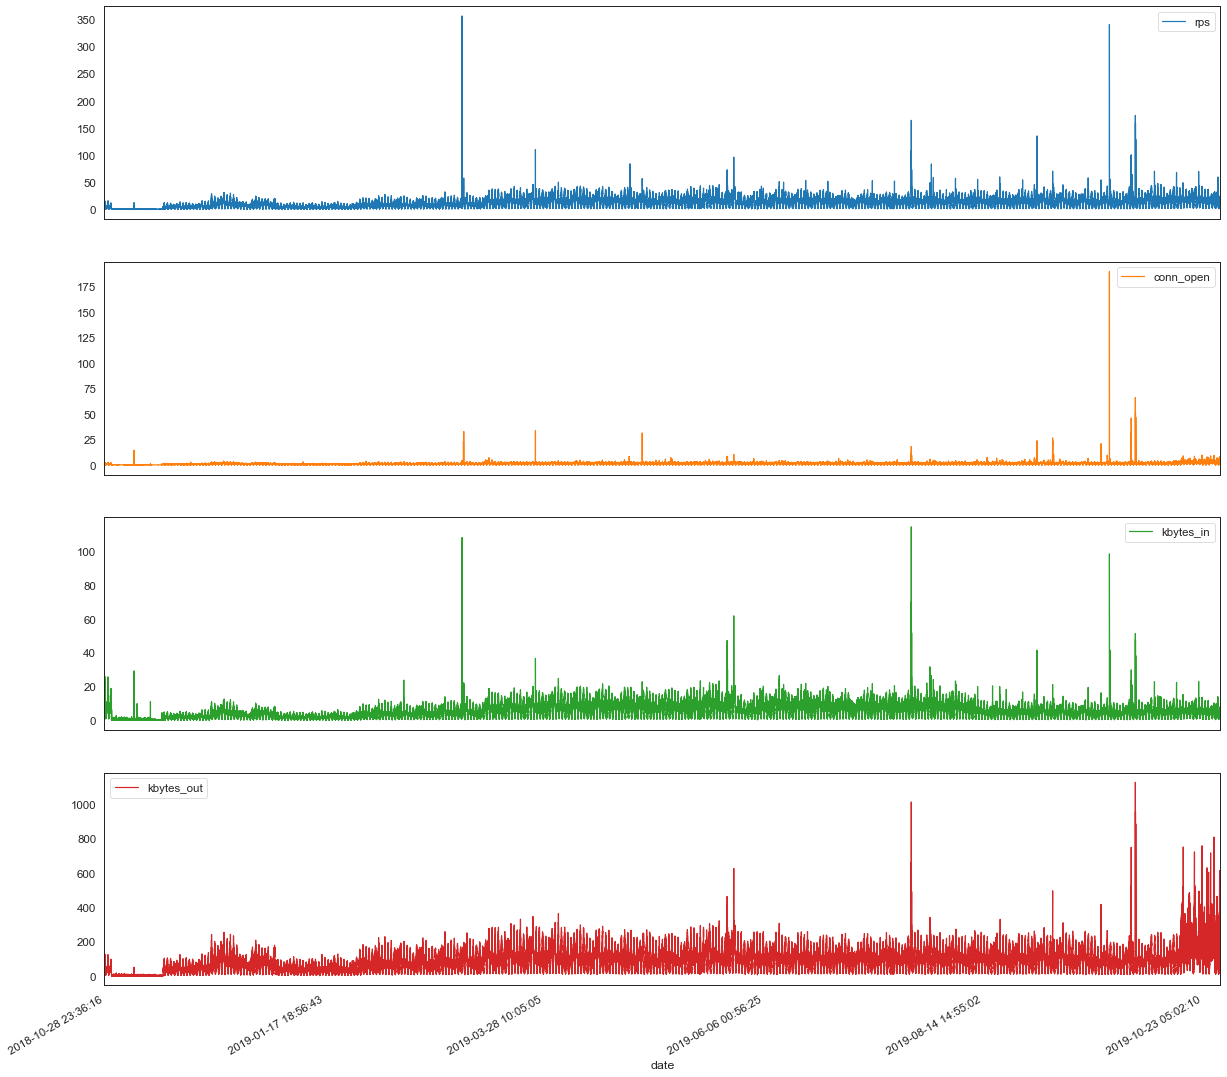

In [55]:

features.plot(subplots=True, figsize=(20,20))

In [58]:
#the first step will be to normalize the dataset using the mean and standard deviation of the training data.
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)


In [59]:
dataset = (dataset-data_mean)/data_std

In [60]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [61]:
past_history = 60
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [62]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (60, 4)


In [63]:
model = Sequential()
model.add(LSTM(60, input_shape=(x_train_single.shape[1], x_train_single.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#TRY MAE later

history = model.fit(x_train_single, y_train_single, epochs=20, batch_size=256, validation_data=(x_val_single, y_val_single), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 406516 samples, validate on 101579 samples
Epoch 1/20
406516/406516 [==============================] - 256s 629us/step - loss: 0.0698 - val_loss: 1.3971
Epoch 2/20
406516/406516 [==============================] - 216s 531us/step - loss: 0.0655 - val_loss: 1.3503
Epoch 3/20
406516/406516 [==============================] - 224s 551us/step - loss: 0.0643 - val_loss: 1.3466
Epoch 4/20
406516/406516 [==============================] - 210s 517us/step - loss: 0.0635 - val_loss: 1.3346
Epoch 5/20
406516/406516 [==============================] - 198s 488us/step - loss: 0.0624 - val_loss: 1.3357
Epoch 6/20
406516/406516 [==============================] - 189s 465us/step - loss: 0.0619 - val_loss: 1.3240
Epoch 7/20
406516/406516 [==============================] - 1145s 3ms/step - loss: 0.0617 - val_loss: 1.3177
Epoch 8/20
406516/406516 [==============================] - 239s 588us/step - loss: 0.0618 - val_loss: 1.3067
Epoch 9/20
406516/406516 [==============================] - 246s 605u

In [64]:
#performance does not look good, try with future_target = 1
past_history = 60
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)


In [65]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (60, 4)


In [66]:
model = Sequential()
model.add(LSTM(60, input_shape=(x_train_single.shape[1], x_train_single.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#TRY MAE later

history = model.fit(x_train_single, y_train_single, epochs=20, batch_size=256, validation_data=(x_val_single, y_val_single), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 406516 samples, validate on 101583 samples
Epoch 1/20
406516/406516 [==============================] - 259s 638us/step - loss: 0.0669 - val_loss: 1.2972
Epoch 2/20
406516/406516 [==============================] - 221s 544us/step - loss: 0.0582 - val_loss: 1.2224
Epoch 3/20
406516/406516 [==============================] - 208s 511us/step - loss: 0.0570 - val_loss: 1.2316
Epoch 4/20
406516/406516 [==============================] - 195s 480us/step - loss: 0.0567 - val_loss: 1.1903
Epoch 5/20
406516/406516 [==============================] - 719s 2ms/step - loss: 0.0562 - val_loss: 1.2024
Epoch 6/20
406516/406516 [==============================] - 237s 582us/step - loss: 0.0557 - val_loss: 1.1564
Epoch 7/20
406516/406516 [==============================] - 221s 544us/step - loss: 0.0553 - val_loss: 1.1224
Epoch 8/20
406516/406516 [==============================] - 256s 630us/step - loss: 0.0555 - val_loss: 1.1410
Epoch 9/20
406516/406516 [==============================] - 247s 608us

# Multi-Step model
In  a multi-step prediction model, given a past history, the model needs to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict sequence of the future

In [107]:
def univariate_multi_step_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i:i+target_size])
  return np.array(data), np.array(labels)

In [108]:
#Use more historical input
univariate_past_history = 60
univariate_future_target = 5

x_train_uni, y_train_uni = univariate_multi_step_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_multi_step_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [109]:
print ('Single window of past history : {}'.format(x_train_uni[0].shape))
print ('\n Target rps to predict : {}'.format(y_train_uni[0].shape))

Single window of past history : (60, 1)

 Target rps to predict : (5,)


In [110]:
x_train_uni.shape

(406516, 60, 1)

In [122]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  #plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(num_in, np.array(history[:]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [115]:
model = Sequential() 
model.add(LSTM(60, return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(Dropout(0.2))
model.add(keras.layers.LSTM(30,activation='relu'))
model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer = keras.optimizers.RMSprop(clipvalue=1.0))
#TRY MAE later

history = model.fit(x_train_uni, y_train_uni, epochs=20, batch_size=256, validation_data=(x_val_uni, y_val_uni), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 406516 samples, validate on 101579 samples
Epoch 1/20
406516/406516 [==============================] - 468s 1ms/step - loss: 0.5685 - val_loss: 0.1295
Epoch 2/20
406516/406516 [==============================] - 1722s 4ms/step - loss: 0.0459 - val_loss: 0.1248
Epoch 3/20
406516/406516 [==============================] - 401s 987us/step - loss: 0.0439 - val_loss: 0.1195
Epoch 4/20
406516/406516 [==============================] - 635s 2ms/step - loss: 0.0431 - val_loss: 0.1145
Epoch 5/20
406516/406516 [==============================] - 490s 1ms/step - loss: 0.0423 - val_loss: 0.1035
Epoch 6/20
406516/406516 [==============================] - 360s 885us/step - loss: 0.0417 - val_loss: 0.1177
Epoch 7/20
406516/406516 [==============================] - 1418s 3ms/step - loss: 0.0413 - val_loss: 0.1178
Epoch 8/20
406516/406516 [==============================] - 438s 1ms/step - loss: 0.0407 - val_loss: 0.1199
Epoch 9/20
406516/406516 [==============================] - 412s 1ms/step - lo

In [116]:
# make predictions with normalization
test_predict = model.predict(x_val_uni)

multi_step_plot(x_val_uni[0], y_val_uni[0], test_predict[0])

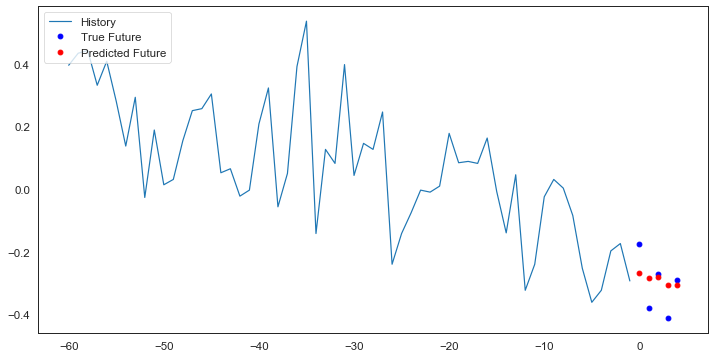

In [125]:
multi_step_plot(x_val_uni[2], y_val_uni[2], test_predict[2])